# TMR4222 Thermal System Exercise 2

## Problem 1
A pipe made of steel with an inner diameter of 50 mm and with a wall thickness of 5 mm is
transferring water of 83 <sup>o</sup>C. The pipe is insulated with a 2 cm pipe insulation material
with a  thermal conductivity of 0.082 W/mK.  The average water flow speed is 2.5 m/s.
Outer room temperature is assumed to be 20 ºC. The thermal contact resistance between the steel
and the insulation can be assumed to be approximately 0.0001 m<sup>2</sup>K/W.

Assuming that the wall temperature both inside and outside of the pipe are equal to the water and
 room temperature, i.e. no convection effects.

### Create a function that returns thermal resistance of a cylinder for the following inputs:
    - radius
    - wall_thickness
    - thermal_conductivity
    - length

The function name should be `get_thermal_resistance_cylinder`. Please see the `thermal_system_calculation.py` file for the detailed guidance.

Use the following code to test your function.

In [1]:
import numpy as np

from thermal_system_calculation import get_thermal_resistance_cylinder, FinConfiguration

radius = 0.07
wall_thickness = 0.01
thermal_conductivity = 130
length = 1

answer = 0.000163478
value_to_test = get_thermal_resistance_cylinder(
    radius=radius,
    wall_thickness=wall_thickness,
    thermal_conductivity=thermal_conductivity,
    length=length
)
assert np.isclose(answer, value_to_test), f"Your value {value_to_test:.5e} is not close to the answer, {answer:.5e}"

### What is the heat loss pr meter for the pipe without insulation?

#### Known

In [2]:
# Known
inner_diameter = 0.05 # m
wall_thickness = 0.005 # m
temperature_water = 83 # degC
temperature_room = 20 # degC

#### Find

In [3]:
heat_loss_per_meter_bare = None

#### Schematic
![Pipe Wall Heat Transfer](pipe_wall_heat_transfer.svg)

### Assumptions
1. No convection is considered. The temperature of the inner wall is equal to the temperature of
water and the temperature of the outer wall is equal to the room temperature.
2. Steady state
3. Material property of the steel is homogeneous and constant

#### Properties

In [4]:
thermal_conductivity_steel = 15 # W/mK

#### Analysis
We can use the equation for the thermal resistance for a cylinder to calculate the heat loss. 

$$R_\mathrm{cond} = \frac{\ln(r_3/r_2)}{2 \pi L k}$$

In [5]:
inner_radius_pipe = inner_diameter / 2

thermal_resistance_pipe_per_meter = get_thermal_resistance_cylinder(
    radius=inner_radius_pipe,
    wall_thickness=wall_thickness,
    thermal_conductivity=thermal_conductivity_steel,
    length=1
)
temperature_diff = temperature_water - temperature_room
heat_loss_per_meter_bare = 1 / thermal_resistance_pipe_per_meter * temperature_diff

print(f"Pipe loses {heat_loss_per_meter_bare:.2f}W/m to the room.")

Pipe loses 32566.69W/m to the room.


### What is the heat loss pr meter for the pipe with insulation not considering the contact
resistance?

In [6]:
#### Known

In [7]:
insulation_thickness = 0.02 # m

In [8]:
#### Find

In [9]:
heat_loss_per_meter_insulated = None

#### Schematic
![pipe insulation heat transfer](pipe_insulation_heat_transfer.svg)

#### Assumptions
1. No convection is considered. The temperature of the inner wall is equal to the temperature of
water and the temperature of the outer wall is equal to the room temperature.
2. Steady state
3. Material property of steel is homogeneous and constant
4. No thermal resistance between the pipe wall and the insulation

#### Properties

In [10]:
thermal_conductivity_insulation = 0.082 # W/mK

#### Analysis

In [11]:
# First calculate the thermal resistance of the insulation
outer_radius_pipe = radius + wall_thickness
outer_radius_insulation = outer_radius_pipe + insulation_thickness
thermal_resistance_insulation_per_meter = get_thermal_resistance_cylinder(
    radius=outer_radius_pipe,
    wall_thickness=insulation_thickness,
    thermal_conductivity=thermal_conductivity_insulation,
    length=1
)

# Then, calculate the heat loss considering total heat resistance
total_resistance_per_meter = thermal_resistance_pipe_per_meter + thermal_resistance_insulation_per_meter
heat_loss_insulation_no_contact_resistance = 1 / (total_resistance_per_meter) * temperature_diff

print(f"Heat loss with insulation without contact resistance is {heat_loss_insulation_no_contact_resistance:.3f} W/m.")

Heat loss with insulation without contact resistance is 136.735 W/m.


### Calculate the the heat loss when the contact resistance considered.

#### Find

In [12]:
heat_loss_insulation_contact_resistance_per_meter = None

#### Schematic
![pipe insulation heat transfer](pipe_insulation_contact_resistance_heat_transfer.svg)

#### Assumpation
Same as above

#### Properties

In [13]:
thermal_resistance_contact_per_area = 10**-4 # m2K/K

#### Analysis

In [14]:
# First calculate the total thermal resistance
import numpy as np
thermal_resistance_contact_per_meter = thermal_resistance_contact_per_area * 2 * np.pi * outer_radius_pipe
total_resistance_per_meter = thermal_resistance_pipe_per_meter + \
                             thermal_resistance_contact_per_meter + \
                             thermal_resistance_insulation_per_meter

# Calculate heat loss
heat_loss_insulation_contact_resistance_per_meter = 1 / total_resistance_per_meter * temperature_diff

print(f"Heat loss with insulation and contact thermal resistance is "
      f"{heat_loss_insulation_contact_resistance_per_meter:.3f}")

Heat loss with insulation and contact thermal resistance is 136.721


We see that the thermal resistance for the contact does not change the heat loss. We can often neglect the part of the heat circuit which has very low thermal resistance. 

## Problem 2 Heat transfer from extended surface

### Implement a function for the extended surface.
Create a function called `get_heat_transfer_1D_fin_with_uniform_cross_section` , in `thermal_system_calculation.py` that returns a tuple of `(heat_transfer_rate, temperature)` for given x and given boundary conditions as follows.

|Case|Tip Condition (x=L)|Temperature Distribution $\theta/\theta_b$|Fin Heat Transfer Rate $q_f$|
|----|-------------------|------------------------------------------|--------------------------|
|A   |Convection heat transfer| $\frac{\cosh m(L-x) + (h/mk)\sinh m(L-x)}{\cosh mL + (h/mk)\sinh
 mL}$ | $M \frac{\sinh mL + (h/mk)\cosh mL}{\cosh mL + (h/mk)\sinh mL}$|
|B   |Adiabatic          |$\frac{\cosh m(L-x)}{\cosh mL}$|$M \tanh mL$|
|C   |Prescrubed temperature|$\frac{(\theta_L / \theta_b)\sinh mx + \sinh m(L-x)}{\sinh mL}$| $M\frac{\cosh mL - \theta_L / \theta_b}{\sinh mL}$|
|D   |Infinite fin ($L \rightarrow \infty$)|$e^{-mx}$|$M$|

The arguments should be
- `x`: length along the axis [m],
- `temp_base`: temperature at the base of the fin [K],
- `temp_surr`: surrounding temperature [K],
- `fin_configuration`: an instance of FinConfiguration containing members of `perimeter`,
`area_cross_section` and `length`
- `h`: convection heat transfer coefficient [W/m<sup>2</sup>K],
- `k`: thermal conductivity of the materials [W/mK],
- `boundary_condition`: kind of boundary condition to apply. See `TipBoundaryConditionForFin`
  class in `thermal_system_calculation.py` given.
- `temp_tip`: (Optional) tempeature at tip [K]. Only required when the boundary condition is
  `boundary_condition == TipBoundaryConditionForFin.Temperature`

For more details, please see the given `thermal_system_calculation.py` for the guidance.

Use the following code to test your function.

In [15]:
from thermal_system_calculation import TipBoundaryConditionForFin, get_heat_transfer_1D_fin_with_uniform_cross_section

parameters = {
    'x': 0.02,
    'temp_base': 500,
    'temp_surr': 300,
    'fin_configuration': FinConfiguration(perimeter=0.032, area_cross_section=0.00012,
                                          length=0.05),
    'h': 100,
    'k': 180,
}
temp_tip = 375

answers = [(30.2095, 477.706), (28.5584, 479.250), (66.3291, 443.931), (52.5814, 456.787)]

for boundary_condition, answer_pair in zip(TipBoundaryConditionForFin, answers):
    parameters['boundary_condition'] = boundary_condition
    if boundary_condition == TipBoundaryConditionForFin.Temperature:
        parameters['temp_tip'] = temp_tip
    value_pair_to_test = get_heat_transfer_1D_fin_with_uniform_cross_section(**parameters)
    print(value_pair_to_test)
    for value, answer in zip(value_pair_to_test, answer_pair):
        assert np.isclose(value, answer), \
        f"Your value {value:.5e} for {boundary_condition} is not close to the answer, {answer:.5e}"

(30.209468920245385, 477.70643342160207)
(28.558369239653548, 479.25037344351244)
(66.32908240563623, 443.9310548108814)
(52.58136552049595, 456.78651748122303)


### Get the temperature distribution
Create a plot of temperature distribution for the each boundary condition as follows:

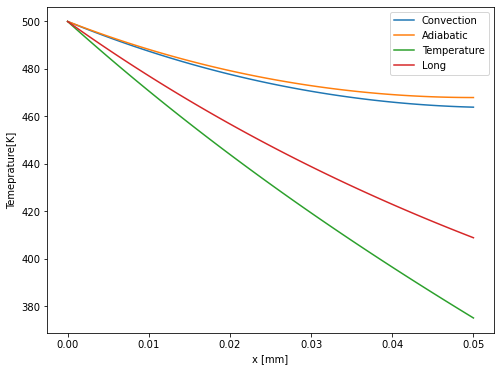

In [16]:
import matplotlib.pyplot as plt

# We will plot for 0 <= x <= legnth
x = np.linspace(0, parameters['fin_configuration'].length, 101)
parameters['x'] = x

fig, ax = plt.subplots(figsize=(8, 6))
for boundary_condition in TipBoundaryConditionForFin:
    parameters['boundary_condition'] = boundary_condition
    if boundary_condition == TipBoundaryConditionForFin.Temperature:
        parameters['temp_tip'] = temp_tip
    heat_transfer_rate, temperature_vector = get_heat_transfer_1D_fin_with_uniform_cross_section(**parameters)
    ax.plot(x, temperature_vector, label=boundary_condition.name)
ax.set_xlabel('x [mm]')
ax.set_ylabel('Temeprature[K]')
ax.legend()
    

### Boundary condition
Which boundary condition is most sensible to use? Evaluate each boundary condition and discuss
 when it is proper to use it.

It is always safe to use the boundary condition with heat convection at the tip. Adiabatic
assumption is quite close to the case B, so it is OK to use it if the accuracy is not of major
concern. Case C should be only used if the temperature at the tip is specifically given. Case D
should be only used when the length is really long. This has be verified with the value of $\tanh mL$

## Problem 4
In this exercise, we will create a python class to get the thermodynamic property of fluid. We will use an open-source library for the thermodynamic properties, called [CoolProp](http://www.coolprop.org), and create a class for the high-level interface. 

First make sure that you have installed coolprop package for python. You can do that by
```commandline
pip install coolprop
```

Your mission is to implement `FluidState` class in `thermal_system_calculation.py`. The basic template is given in the module. The `FluidState` class will have attributes of
- fluid: the name of the fluid given by the Fluid enum class
- pressure_pa: the pressure of the fluid in Pa
- temp_k: the temperature of the fluid in K
- characteristic_length: Characteristic length of the flow condition

From the class instance, you will be able to access
- k: the thermal conductivity of the fluid
- dynamic_viscosity
- density
- cp: the specific heat capacity at constant pressure

You will need to implement
- property for Prantdl number. See `prantdl_number` getter function
- method for getting Nusselt number with an input of convection thermal conductivity, h. See `get_nusselt_number` method.
- method for getting h from Nusselts number. See `get_h_from_nusselt_numberz` method
- method for getting Reynolds number with an input of fluid velocity. See `get_reynolds_number` method

At the end of the exercise, you will have created your own high-level interface for the fluid thermodynamic property library with additional

## Probelm 5
In this exercise, will will build a calculation libraries for forced convection for 

### Forced Convection over flat plate at isothermal conditions
First we will implement a class for the forced convection over flat plate at isothermal condition. The template for the class is found with the class name, `ForcedConvectionFlatPlateIsothermSurface`. Note that this class inherits the abstract class `ForcedConvection` and `Convection` which are inherited by other forced convection classes. You should study these abstract class especially the constructor method, `__init__` to see how an instance is initialized. 

For `Convection` class, you should implement `h` property method which calculates the convection coefficient from the Nusselt number. Note that Nusselt number is not implemented in this class but those classes that inherits this class. You need to also implement `get_heat_transfer_rate` method. 

For `ForcedConvectionFlatPlateIsothermSurface`, you should implement the properties, `critical_length`, `critical_lenth_ratio` and `nusselt_number`. For `nusselt_number`, you should calculate the value depending on its flow boundary layer conditions. 

### Convection for cross-flow for cylinder / non-cylindrical object
Template for `ForcedConvectionCylinderCrossFlow` is given. You should implement the property, `nusselt_number` for the class.

For circular cylinder in a cross-flow, we can use Churchill and Bernstein's equation. 
$$Nu_L = 0.3 + \frac{0.62Re_D^0.5 Pr^{1/3}}{\left[1 + 0.4 / Pr)^{2/3}\right]^0.25}
        \left[1 + \left(\frac{Re_D}{282000}\right)^{5/8}\right]^{4/5}
$$
Make sure that the code gives a warning for the invalid conditions. 

For the non-circular cylinder, we will implement the empirical formula for
`ForcedConvectionNonCircularCylinderCrossFlow`,
$$\overline{Nu}_D = C Re_D^m Pr^{1/3}$$
where $C$ and $m$ are given as follows:
![Constants for equation](constants_for_non_circular_cylinder.png)

Note that the constructor for this class requires an argument `geometry` which is of
`NonCircularCylinderGeometry` enum class type. You should use this attribute to distinguish
between the shapes.

### Convection for banks of tubes
Template for `ForcedConvectionTubeBanksCrossFlow` is given in the `thermal_system_calculation.py`
. You should implement `nusselt_number` property. For this class, an additional required argument
 for the constructor is passed, `configuration` which is of class type, `TubeBankConfiguration`
 which has been implemented in the code. Note that you should implement the method
 `get_maximum_velocity`. You should inspect this class to understand which arguments are passed.

For the calculation of `nusselt_number`, we will use the correlation by Zukauskas.
$$
\overline{Nu}_D = C_1 C_2 Re_{D, mathrm{max}}^m Pr^0.36 \frac{Pr}{Pr_s}^{1/4}
$$

$C_1$ and $m$ are given as follows:
![constants for flow accorss banks of tubes](constants_tube_bank.png)

In addition, we need the following additional properties implemented.
- `C_2`: `correction_factor`, See the table below.
- `Re_{D,\mathrm{max}}`: `reynolds_number`, We need to calculate the maximum velocity first. The
maximum velocity should be implemented in the `TubeBankConfiguration` class.
- `Pr_s`: `prantdl_number_surface`, Prandtl number at the surface temperature.
![correction factor for flow accorss banks of tubes](correction_factor_tube_bank.png)

Finally, you should override `get_heat_transfer_rate` method because you have to use the logarithmic
mean temperature for the temperature difference. You will have to implement the properties
`log_mean_temperature_difference` and `temp_out` also.